# Sparse GP regression with SMC

In [1]:
# !pip install git+ssh://git@github.com/UncertaintyInComplexSystems/bayesianmodels.git
# !pip install numpy==1.23.5

Import the necessary stuff:

In [2]:
import sys
import os
import time
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
import numpy as np

plt.style.use('Solarize_Light2')

# os.environ['JAX_ENABLE_X64'] = 'True'
import jax
from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.sparsegp import SparseGPModel

# confirm precision setting
x = jrnd.uniform(jrnd.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype # --> dtype('float64')

dtype('float64')

## utils

In [3]:
def plot_cov(cov, title, show_negative=True, figsize=(4, 12)):    
    # transform jax array to numpy array to allow mutation
    cov_np = np.array(cov)  

    cmap = plt.cm.plasma

    # replace negativ values with nan to make them visible in the plot
    if show_negative:
        cmap.set_bad((1, 0, 0, 1))
        for c in np.argwhere(cov_np < 0):
            cov_np[c[0], c[1]] = np.nan
    
    fig, ax = plt.subplots(figsize=figsize) 
    image = plt.imshow(cov_np, cmap=cmap) 
    # creating new axes on the right side of (ax) for the colorbar
    # this new axis has the same hight as the original axis
    divider = make_axes_locatable(ax) 
    colorbar_axes = divider.append_axes("right", 
                                        size="10%", 
                                        pad=0.1)
    plt.colorbar(image, 
                 cax=colorbar_axes, 
                 ticks=None if show_negative else [np.min(cov_np), np.mean(cov_np), np.max(cov_np)])

    # colorbar_axes.ticklabel_format(style='plain')
    ax.set_title(title)
    

## simulate data
Simulate some data from a known GP so we can look at the inference of the hyperparameters):

In [4]:
random_random_seed = np.random.randint(0, 10000 + 1)
print('seed:', random_random_seed)
# to try: 1106, 5368

seed: 7195


x: mean 0.0, std 0.5831529302570125


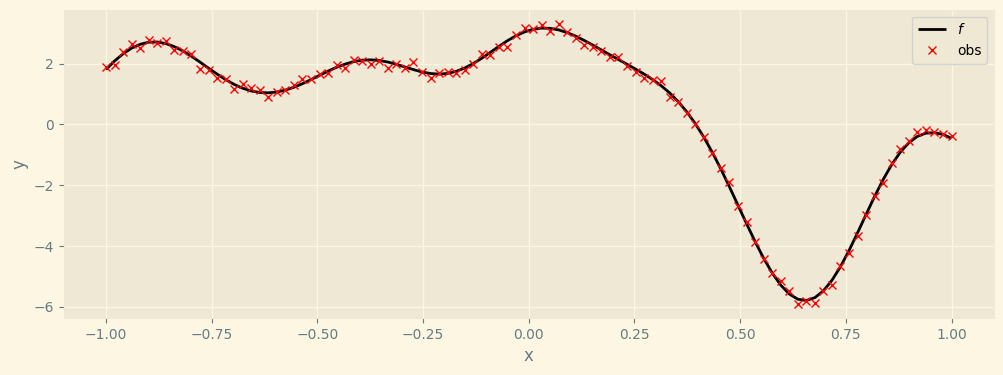

In [5]:
key = jrnd.PRNGKey(5368)

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.1
n = 100
x = jnp.linspace(-1, 1, n)[:, jnp.newaxis]  # NOTE: Rossie seem to use x-domain of [-1, 1]

x_mean = jnp.mean(x)
x_std = jnp.std(x)
print(f'x: mean {jnp.round(x_mean, decimals=10)}, std {x_std}')

kernel = jk.RBF()
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_),
                            x=x, y=x) + 1e-6*jnp.eye(n)
# plot_cov(K, 'true cov')

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))
f_true = jnp.dot(L, z) + jnp.zeros_like(z)  # NOTE: True GP had mean=1

key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'$f$')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([0., 1.])
plt.legend()

# WIP implementing

Set up the GP models, either with $\mathbf{f}$ sampled explicitly, or with $\mathbf{f}$ margnalized out (theobvious choice for a Gaussian likelihood, but sampling is shown for pedagogical reasons):

## Prior & init. model

In [8]:
# prior over covariance hyperparameters, likelihood, and inducing inputs.
# TODO: Q: Can I add shapes here to account for num_of_particles?

num_inducing_points = 60

priors = dict(
    kernel=dict(  # Rossi uses lognormal priors over kernel parameters. 
        # NOTE: Rossi uses a seperate lengthscale per feature.
        #   - do they mean locations with features? Or is this about multiple inputs?

        lengthscale = dx.Transformed(
            dx.Normal(loc=1., scale=1.), 
            tfb.Exp()), # NOTE: log Normal as in Rossi
        # lengthscale = dx.Deterministic(loc=lengthscale_),

        variance = dx.Transformed(
            dx.Normal(loc=.05, scale=1.), 
            tfb.Exp())), # log Normal as in Rossi
        # variance = dx.Deterministic(loc=output_scale_)),

    # likelihood=dict(  # actually not modeled in Rossi
        #obs_noise = dx.Transformed(
        #    dx.Normal(loc=0., scale=1.), 
        #    tfb.Exp())
        # obs_noise = dx.Deterministic(loc=obs_noise_)  # HACK: Using true obs_noise
        #),

    inducing_inputs_Z=dict( 
    # HACK using mean and scaled std of x to match prior to the data distribution
    # TODO: Currently not used as Z's are evenly spread using linspace
    # NOTE: Defining distribution over Z directly results in an error
        # the __init__ tries to sample from each distribution in the prior.
        mean=dx.Deterministic(
            loc=jnp.ones(shape=num_inducing_points) * x_mean),
        scale=dx.Deterministic(
            loc=jnp.ones(shape=num_inducing_points) * x_std *.6)))

gp_sparse = SparseGPModel(x, y, cov_fn=jk.RBF(), priors=priors, num_inducing_points=num_inducing_points)  
# NOTE Defaults to likelihood=Gaussian()

num_particles = 3
num_mcmc_steps = 10_000
sampling_parameters = dict(num_particles=num_particles, 
                           num_mcmc_steps=num_mcmc_steps)

## first gibbs_state

# init_fn:
X -1.0 1.0
params Z: [5.32907052e-17 5.32907052e-17 5.32907052e-17]..., [0.34989176 0.34989176 0.34989176]...
samples_Z: (100, 1) [[-1.        ]
 [-0.97979798]
 [-0.95959596]]...
mean_u (60,)
samples_u: (100,)
mean_gp: (100,)
cov_gp (100, 100) float64
cov_gp min, avg, max -3.2184445108995874e-08 2.999999965467957e-08 2.244849210491061e-06
samples_f (100,) [3.53292322 3.23777927 2.96026383 2.70781511 2.46782477]

# Gibbs-State:
lengthscale 1.9937929633707197
variance 0.574615138762647
mean (60,)
scale (60,)
Z (100,)
u (100,)
f (100,)
dev 7



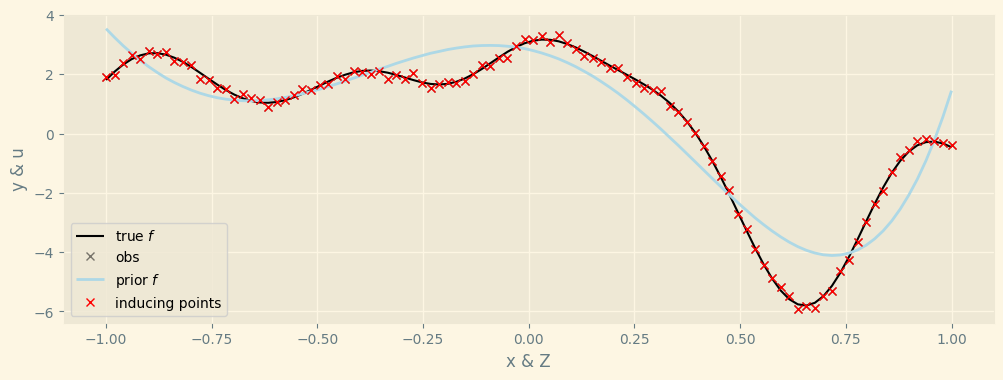

In [9]:
# %%script false --no-raise-error  # hack to skip execution of a cell

# playground, for testing only
gibbs_state = gp_sparse.init_fn(
    key=key, 
    num_particles = sampling_parameters['num_particles'])

print('\n# Gibbs-State:')
# print all keys and len/shape of corresponding data
for k in gibbs_state.position.keys():
    try:
        print(k, 
              gibbs_state.position[k]
              if len(gibbs_state.position[k].shape) == 0 
              else gibbs_state.position[k].shape, 
              end='\n')
    except:
        print(k, len(gibbs_state.position[k]), end='\n')
print()

# plot true function, inducing points, estimated function
plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1)
plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5)
plt.plot(x, gibbs_state.position['f'], label=r'prior $f$', color='lightblue')
plt.plot(
    gibbs_state.position['Z'], 
    gibbs_state.position['u'], 
    'x', 
    label='inducing points', 
    color='red',
    alpha=1.)
plt.xlabel('x & Z')
plt.ylabel('y & u')
# plt.xlim([0., 1.])
plt.legend()
plt.show()

# plot covariance matrices
def _plot_covs():
    for t in gibbs_state.position['dev'].keys():
        c = gibbs_state.position['dev'][t]
        print(f'{t}: {c.shape}')
        if t == 'cov_gp':
            plot_cov(c, t, show_negative=False, figsize=(8, 12))
            plot_cov(c, t + '\nred = negative values', 
                    show_negative=True, 
                    figsize=(8, 12))
        else:
            plot_cov(c, t, show_negative=False)

        plt.show()

# _plot_covs()

## 'manual' gibbs sampling

In [ ]:
# utils: pretty print gibbs state, IPython progress bar

def update_progress(progress, extra=''):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, extra)


def plot_posterior(gibbs_state_hist, num_of_samples=100, iter=''):
    """
    Plot true function and posterior samples
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5)
    plt.plot(
        gibbs_state_hist[-1].position['Z'], 
        gibbs_state_hist[-1].position['u'], 
        'x', 
        label='inducing points', 
        color='red',
        alpha=1)

    plt.plot(
        x, 
        gibbs_state_hist[0].position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1)

    # get last `num_of_states` gibbs states
    f_samples = jnp.array([s.position['f'] 
                        for s 
                        in gibbs_state_hist[-1*num_of_samples -1: -1]])

    # plot each sample
    '''for i in range(f_samples.shape[0]):  # negativ indexing to select last elements
        plt.plot(x, f_samples[i], 
                color='orange',
                alpha=0.1)'''
        
    # plot average and confidence intervals
    f_mean = jnp.mean(f_samples, axis=0)
    f_hdi_lower = jnp.percentile(f_samples, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_samples, q=97.5, axis=0)
    ax = plt.gca()
    ax.plot(x, f_mean, label='mean f~GP', color='green', lw=1.5)
    ax.fill_between(
        x.flatten(), f_hdi_lower, f_hdi_upper, 
        alpha=0.5, color='lightgreen', lw=0)
    ax.set_ylim(
        jnp.min(f_true) - 1, 
        jnp.max(f_true) + 1)

    plt.title(f'last {f_samples.shape[0]} posterior samples, iter {iter}')
    plt.legend()
    plt.savefig(f'results/posterior_iter{iter}.png')
    # plt.savefig(f'posterior.png')
    plt.show()
    
def plot_training_history(gibbs_state_hist):
    # Plot training history
    hist_lengthscale = [s.position['lengthscale'] for s in gibbs_state_hist]
    hist_variance = [s.position['variance'] for s in gibbs_state_hist]
    hist_obs_noise = [s.position['obs_noise'] for s in gibbs_state_hist]

    plt.figure(figsize=(12, 4))
    cmap = plt.colormaps.get_cmap('Set1')
    plt.plot(hist_lengthscale, label='lengthscale', color=cmap(0))
    plt.plot(hist_variance, label='variance', color=cmap(1))
    plt.plot(hist_obs_noise, label='obs noise', color=cmap(2))
    plt.axhline(lengthscale_, linestyle='--', color=cmap(0))
    plt.axhline(output_scale_, linestyle='--', color=cmap(1))  # true gp variance
    plt.axhline(obs_noise_, linestyle='--', color=cmap(2))
    plt.xlabel('Gibbs iterations')
    plt.legend()
    plt.savefig(f'results/train_hist.png')
    plt.show()

def plot_u_trajectories(gibbs_state_hist):
    # plot u trajectories
    u_samples = jnp.array([s.position['u'] 
                    for s in gibbs_state_hist])

    iter_idx = range(len(gibbs_state_hist))
    color = plt.cm.hsv(np.linspace(0, 1, u_samples.shape[1]))

    plt.figure(figsize=(12, 4))
    ax = plt.gca()
    ax.set_facecolor('grey')
    for i in range(u_samples.shape[1]):
        plt.plot(iter_idx, u_samples[:, i], alpha=0.7, color=color[i], lw=1)
    plt.title('results/trajectories of u samples')
    # plt.savefig(f'train_hist_u.png')
    plt.show()

In [ ]:
%%time
# %%script false --no-raise-error  # hack to skip execution of a cell

gibbs_state_hist = [gibbs_state]
for i in range(1, sampling_parameters['num_mcmc_steps']):
    t_start = time.time()

    key, key_gibbs = jrnd.split(key)  # TODO: Should I reuse the same key every iteration instead of splitting a new one?
    gibbs_state_, _ = gp_sparse.gibbs_fn(key_gibbs, gibbs_state_hist[-1], sampling_parameters)
    gibbs_state_hist.append(gibbs_state_)
    
    # dumb current gibbst state history
    if i % 100 == 0:
        file = open(f'results/gibbs_state_hist.pkl', 'wb')
        pickle.dump(gibbs_state_hist, file)
        file.close()

    # update progressbar
    if i % 10 == 0:
        update_progress(i / sampling_parameters["num_mcmc_steps"])

    # show and save plots
    if (i % 50 == 0) and (i > 0):
        plot_posterior(gibbs_state_hist, num_of_samples=1_000, iter=i)
        plot_u_trajectories(gibbs_state_hist)
        plot_training_history(gibbs_state_hist)

    if i % 10 == 0:
        print(f'    iter {i}, duration: {jnp.round(time.time() - t_start, decimals = 3)} sec')

update_progress(1)
plot_posterior(
    gibbs_state_hist, 
    num_of_samples=1_000, 
    iter=sampling_parameters['num_mcmc_steps'])
plot_u_trajectories(gibbs_state_hist)
plot_training_history(gibbs_state_hist)

---

# hidden
Run inference:

In [ ]:
%%script false --no-raise-error  # HACK skipping cell

%%time

# trying to do multiple gibbs update using UICS functionality,
key, gpl_key = jrnd.split(key)
gibbs_states = gp_sparse.inference(
    gpl_key, 
    mode='gibbs', 
    sampling_parameters=sampling_parameters)

In [ ]:
%%time

key, gpl_key = jrnd.split(key)
lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(gpl_key,
                                                                mode='gibbs-in-smc',
                                                                sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps))

Plot posteriors of hyperparameters for both models:

In [ ]:
trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))


num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau')

_, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True,
                       sharex='col', sharey='col', figsize=(12, 6))
axes = np.expand_dims(axes, axis=0)  # quick fix as I removed a whole row of plots

for m, particles in enumerate([lgp_particles]):
    for j, var in enumerate(trainables):
        ax = axes[m, j]
        pd = particles.particles[var]
        # There are some outliers that skew the axis
        pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        pd_filtered = jnp.extract(pd>pd_l, pd)
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        ax.hist(pd_filtered, bins=30, density=True, color='tab:blue')
        if var in symbols and m==1:
            ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('Latent GP', rotation=0, ha='right')

if len(ground_truth):
    for j, var in enumerate(trainables):
        axes[0, j].axvline(x=ground_truth[var], ls='--', c='k');

And plot the posterior predictive of $\mathbf{f}$:

In [ ]:


x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True,
                            sharey=True, constrained_layout=True)
axes = np.expand_dims(axes, axis=0)  # quick fix as I removed a whole row of plots

for j, gp in enumerate([gp_latent]):
    key, key_pred = jrnd.split(key)
    f_pred = gp.predict_f(key_pred, x_pred)

    ax = axes[j, 0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

    ax = axes[j, 1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

    ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
    ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                    alpha=0.2, color='tab:blue', lw=0)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-4., 5.])
    ax.set_xlabel(r'$x$')

axes[0, 0].set_title('SMC particles')
axes[0, 1].set_title('Posterior 95% HDI')

axes[0, 0].set_ylabel('Latent GP', rotation=0, ha='right');